### Introduction: This project is mainly use deep learning method to predict the healthy condition of the test leaves.
Firstly, let' s show a video about how data scientists use TensorFlow to detect disease in Cassava plants in Africa.

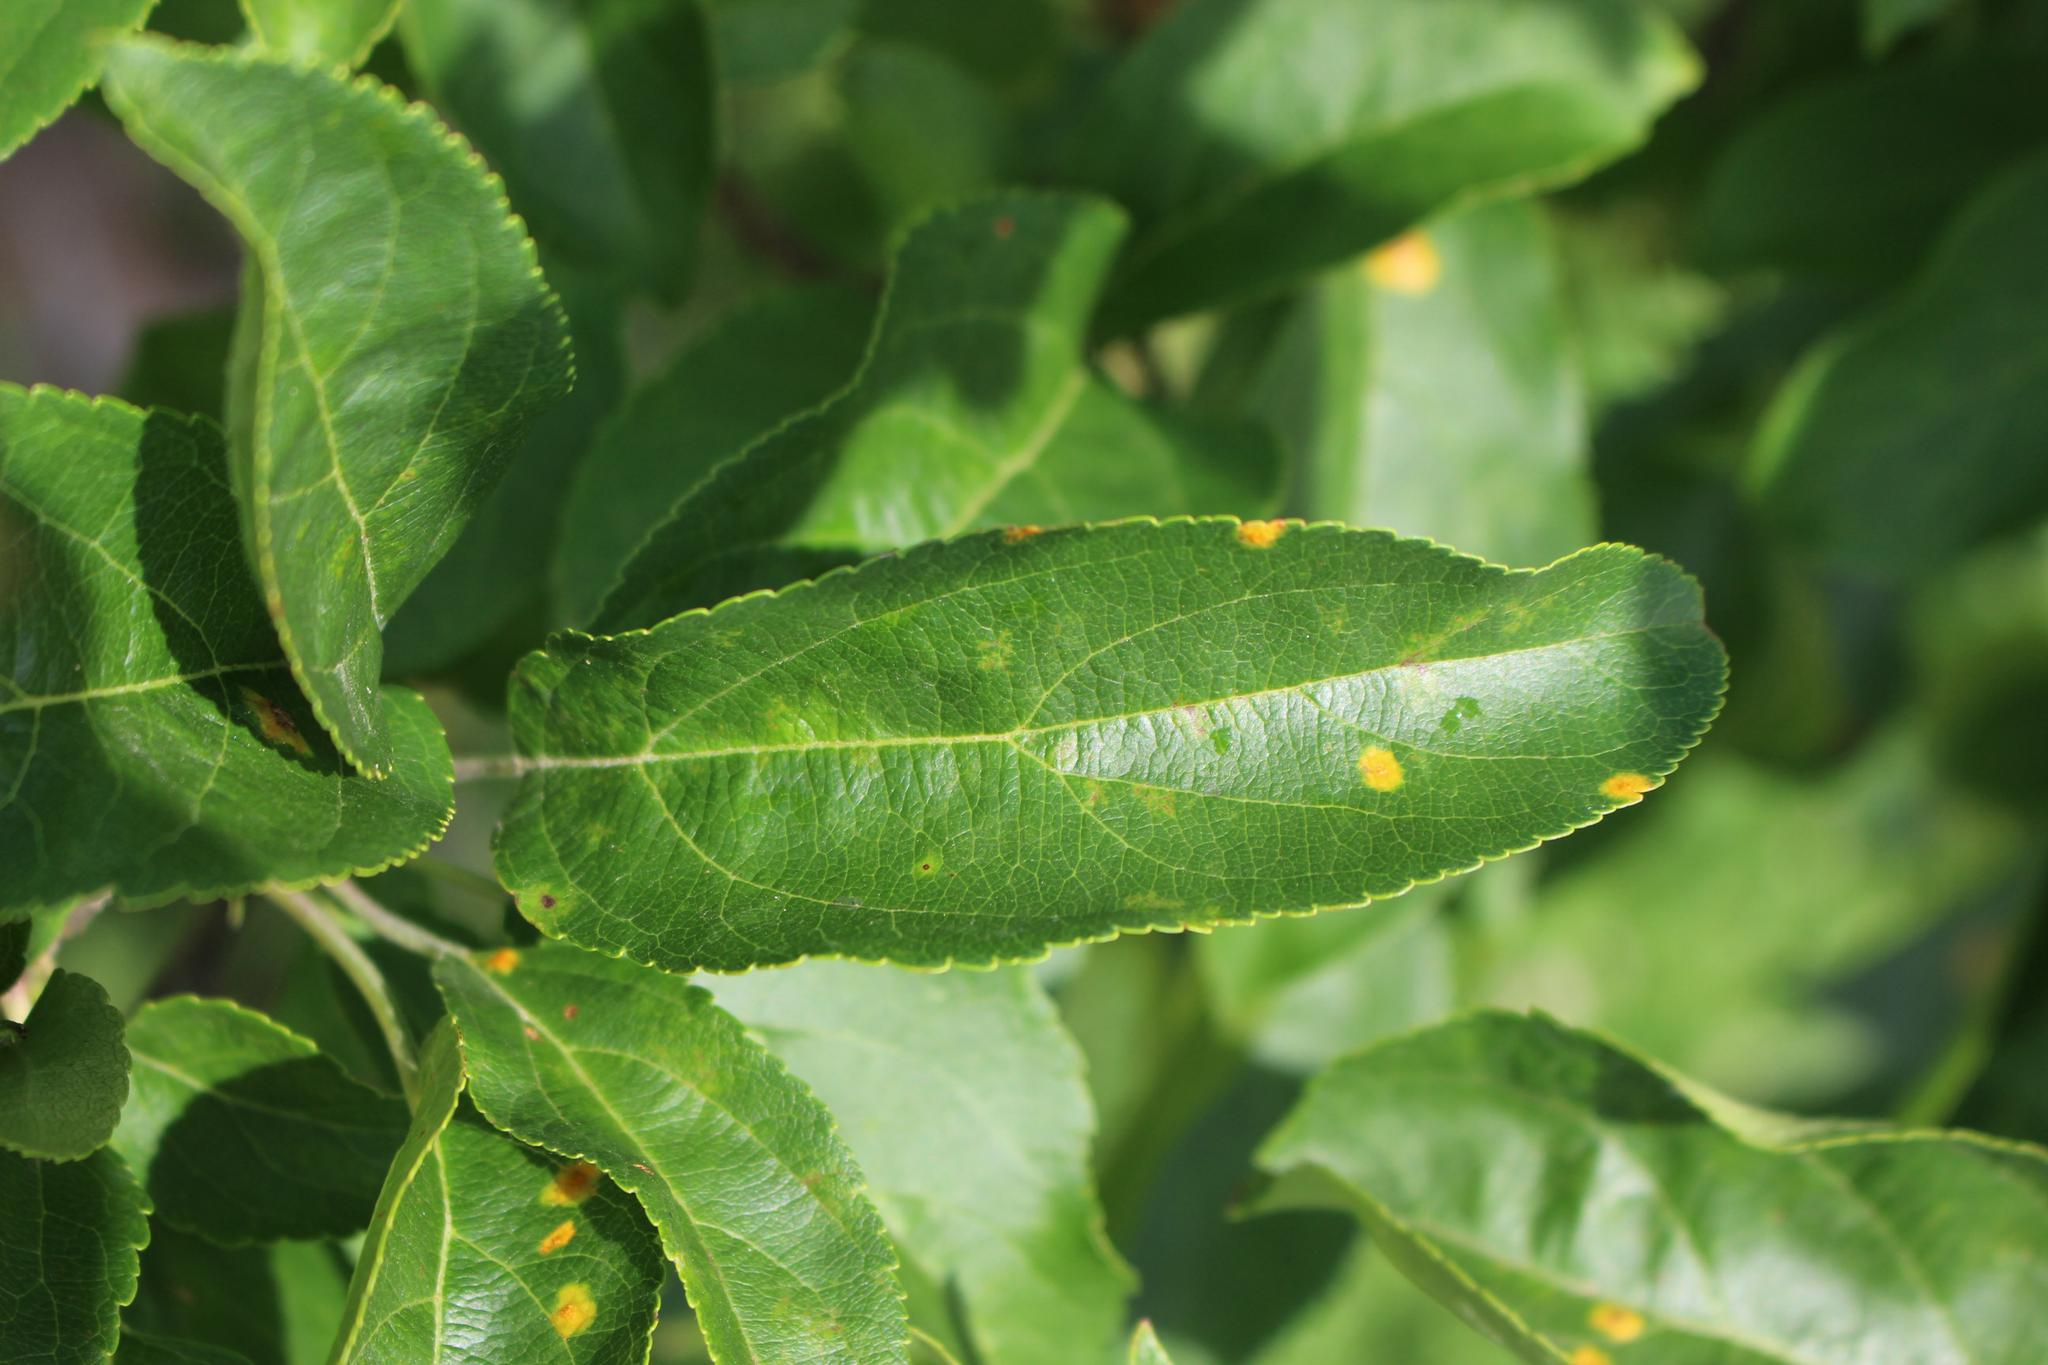

In [1]:
from IPython.display import Image
Image(filename='images/test_0.jpg')

In [2]:
from IPython.display import HTML


In [3]:
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/NlpS-DhayQA?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

## Contents
### 1.EDA
### 2.Image processing and augmentation
### 3.Modeling

### EDA
#### upload the necessary modules

In [4]:
!pip install -q efficientnet

In [5]:
import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
import os
import re
import gc
import math
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
from IPython.display import SVG
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

Using TensorFlow backend.


In [7]:
np.random.seed(0)
tf.random.set_seed(0)
import warnings
warnings.filterwarnings('ignore') 

In [8]:

sub = pd.read_csv("sample_submission.csv")
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

In [9]:
EPOCHS=20
SAMPLE_LEN=100
IMAGE_PATH='/images/'

In [10]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [11]:
test_data.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [12]:
import cv2

In [13]:
#Load sample images
def load_image(image_id):
    file_path=image_id+'.jpg'
    image=cv2.imread(IMAGE_PATH+file_path)
    print(image)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [21]:
train_images = train_data['image_id'][:SAMPLE_LEN].progress_apply(load_image)

  1%|          | 1/100 [00:00<00:00, 415.85it/s]

None


error: OpenCV(4.0.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [17]:
fig=px.imshow(cv2.resize(train_images[0], (205,136)))
fig.show()

TypeError: Expected cv::UMat for argument 'src'

In [22]:
#Channel distrbutions
red_values=[np.mean(train_images[idx][:,:, 0]) for idx in range(len(train_images))]
green_values=[np.mean(train_images[idx][:,:,1]) for idx in range(len(train_images))]
blue_values=[np.mean(train_images[idx])[:,:,1] for idx in range(len(train_images))]
values=[np.mean(train_image[idx]) for idx in range(len(train_images))]

NameError: name 'ids' is not defined

In [23]:
#All channel values
fig=ff.create_distplot([values], group_labels=['Channels'], colors=['purple'])
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of channel values')
fig.data[0].marker.line.color='rgb(0,0,0)'
fig.data[0].marker.line.width=0.5
fig

NameError: name 'ff' is not defined

In [24]:
#Red channel values
fig=ff.create_distplot([red_values], group_labels=['R'], colors='red')
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of red channel values')
fig.data[0].marker.line.color='rgb(0,0,0)'
fig.data[0].marker.line.width=0.5
fig

NameError: name 'ff' is not defined

In [ ]:
#green channel values
fig=ff.create_distplot([green_values], group_labels=['G'], colors='green')
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of green channel values')
fig.data[0].marker.line.color='rgb(0,0,0)'
fig.data[0].marker.line.width=0.5
fig

In [ ]:
#blue channel values
fig=ff.create_distplot([blue_values], group_labels=['B'], colors='blue')
fig.update_layout(showlegend=False, template='simple_white')
fig.update_layout(title_text='Distribution of blue channel values')
fig.data[0].marker.line.color='rgb(0,0,0)'
fig.data[0].marker.line.width=0.5
fig

In [ ]:
#All channel values
fig=go.Figure()
for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx==0:
        color='Red'
    if idx==1:
        color='Green'
    if idx==2:
        color='blue'
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))
fig.update_layout(yaxis_title='Mean value', xaxis_title='Color channel', title='Mean value vs. Color channel', 
                  template='plotly_white')

In [ ]:
fig=ff.create_distplot([red_values, green_values, blue_values],
                      group_labels=['R','G','B'],
                      colors=['red','green','blue'])
fig.update_layout(title_text='Distribution of red channel values', template='simple_white')
fig.data[0].marker.line.color='rgb(0,0,0)'
fig.data[0].marker.line.width=0.5
fig.data[1].marker.line.color='rgb(0,0,0)'
fig.data[1].marker.line.width=0.5
fig.data[2].marker.line.color='rgb(0,0,0)'
fig.data[2].marker.line.width=0.5

#### From the above plots, the colors can be compared.

In [27]:
def visualize_leaves(cond=[0,0,0,0], cond_cols=['healthy'], is_cond=True):
    if not is_cond:
        cols, rows=3, min([3, len(train_images)//3])
        fig, ax=plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
        for col in range(cols):
            for row in range(rows):
                ax[row, col].imshow(train_images.loc[train_imates.index[-row*3pcol-1]])
        return none
   cond_0='healthy=={}'.foramt(cond[0])
   cond_1='scab=={}'.format(cond[1])
   cond_2='rust=={}'.format(cond[2])
   cond_3='multiple_diseases=={}'.format(cond[3])
    
   cond_list=[]
   for col in cond_cols:
        if col=='healthy':
            cond_list.append(cond_0)
        if col=='scab':
            cond_list.append(cond_1)
        if col='rust':
            cond_list.append(cond_2)
        if col='multiple_diseases':
            cond_list.append(cond_3)
   data=train_data.loc[:100]
   for cond in cond_list:
       data=data.query(cond)
    
   images=train_images.loc[list(data.index)]
   cols, rows=3, min([3, len(images)//3])
    fig, ax=plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
    for col in range(cols):
        for row in range(rows):
            ax[row, col].imshow(images.loc[images.index[row*3+col]])
    plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)

In [28]:
#healthy leaves
visualize_leaves(cond=[1,0,0,0], cond_cols='healthy')

NameError: name 'visualize_leaves' is not defined

In [ ]:
#Leaves with scab
visualize_leaves(cond=[0,1,0,0], cond_cols=['scab'])

In [ ]:
#Leaves with rust
visualize_leaves(cond=[0,0,1,0], cond_cols=['rust'])

In [ ]:
#Leaves with multiple diseases
visualize_leaves(cond=[0,0,0,1], cond_cols=['multiple_disease'])

In [ ]:
### Visulize the target
#all labels together
fig = px.parallel_categories(train_data[["healthy", "scab", "rust", "multiple_diseases"]], color="healthy", \
                             color_continuous_scale="sunset",\
                             title="Parallel categories plot of targets")
fig

In [ ]:
#Pie chart
fig=go.Figure([go.Pie(labels=train_data.columns[1:],
                     values=train_data.iloc[:,1:].sum().values)])
fig.update_layout(title_text='Pie chart of targets', template='simple_white')
fig.data[0].marker.line.color='rgb(0,0,0)'
fig.data[0].marker.line.width=0.5
fig.show()

In [ ]:
#healthy distribution
train_data["Healthy"] = train_data["healthy"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Healthy", title="Healthy distribution", color="Healthy",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [ ]:
#scab distribution
train_data["Scab"] = train_data["scab"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Scab", color="Scab", title="Scab distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [ ]:
#rust distribution
train_data["Rust"] = train_data["rust"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Rust", color="Rust", title="Rust distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [ ]:
#Multiple distribution
train_data["Multiple diseases"] = train_data["multiple_diseases"].apply(bool).apply(str)
fig = px.histogram(train_data, x="Multiple diseases", color="Multiple diseases", title="Multiple diseases distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

### Image processing and augmentation